# Kinetic modeling of hemodialysis

During this lab, two models (one and two compartment) of hemodialysis system have been studied to understand and see how they are able to estimate relevant parameters for patients subjected to this treatment. We have been able to analyze them qualitatively, extract parameters and see how they fluctuate by changing the inputs or by doing simplifications. Finally, we have also understood when using simplified models is good enough and when it can cause severe miscalculations that could lead to fatal outcomes.

### Importing libraries

We are gonna import some libraries which will be useful such as numpy, matplotlib and odeint from Scipy.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## 1. Solute removal modeling using one-compartment model

The concentration of urea among time in the body can be defined by the following equation:

$$V \frac{dC}{dt} = -QCE + m$$

- **C**: blood urea concentration
- **m**: Metabolic production rate 
- **K** = Dialyzer clearance 
- **V**: blood volume 

### a) Identify input variables to the script

In [2]:
m = 7 # metabolic production rate
V = 50000 # total volume in ml
labels=["HD3x","HD6x","HD6xn"] # labels of the three cases
yo = 1 # initial urea concentration (initial conditions)
k_vals= [[(3, 219), 272], [(6, 147), 277], [(6, 401), 170]] # list of lists [(num_sessions, duration), k_value]

### b) Define a function that describes the dialyzer behavior

In [3]:
# We define a time function that will take the k value and change the k value among time (opening and closing)
# the dialyzer
def temps(t, k_val):
    if (t%tcd)>td:
        k=0
    else:
        k=k_val
    return k

In [4]:
# Function that describe the dyalizer behavior
def equ(y_at_t,t,m,V,k_val):
    '''
    Inputs:
        - m: urea production rate in mg/min
        - V: total volume of blood in ml
        - k_val: value of k in ml/min
        
    Output:
        - Function that will be introduced in Odeint'''
    C=y_at_t
    dcdt=(-temps(t, k_val)*C+m)/V
    return np.array(dcdt)

In [5]:
# Defining a plot definition which allows changing conditions and number of weeks to have a clear idea

def plot_model(k_vals, n_sem, labels, V, m = 7, yo = 1, colors=["orangered","steelblue","forestgreen"]):
    '''
    Inputs:
        - k_vals: initial conditions in a list of lists with the form
        [[num_sessions, duration_session(min)], k_value]
        - n_sem: number of weeks to plot
        - labels: labels of the plots, same length as k_vals
        - V: total volume of blood
        - m: urea production rate im mg/min
        - yo: initial concentration
        - colors: colors of the labels, same length as k_vals
        
        
    Outputs:
        - plot: plot with all the conditions indicated'''
    
    global td, tcd #because we are working with a function
    tsem=7*24*60*n_sem #Converting weeks to minutes

    plt.figure(figsize=(8, 6)) #change dimensions plot
    plt.style.use("ggplot")
    ts=np.linspace(0,tsem,num=tsem) #We create the time vector

    for i in range(len(k_vals)):
        
        nses = k_vals[i][0][0]*n_sem
        td = k_vals[i][0][1]
        tcd = tsem/nses
        
        Y=odeint(equ,yo,ts,args=(m,V,k_vals[i][1]),hmax=1.0)
        plt.plot(ts,Y, label=labels[i],color=colors[i])
        plt.xlabel("Time (mins)",fontsize=11)
        plt.ylabel("Concentration of urea (mg/ml)",fontsize=11)
        plt.title(f"Numerical simulation one-compartment during {n_sem} week")
        ax = plt.gca()
        ax.set_facecolor('white')
        ax.axhline(0,color='gray',linewidth="0.5") # x = 0
        ax.axvline(0,color='gray',linewidth="0.5") # y = 0
        plt.legend()

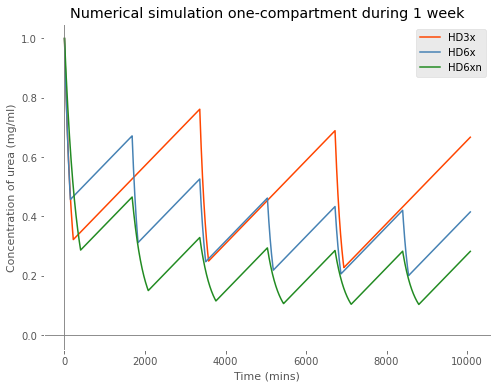

In [6]:
plot_model(k_vals, n_sem=1, labels=labels, V=V, m=m, yo=yo); #it's possible to change conditions

### c) Find the following values
**Find the time required to reduce the initial BUN to BUN/e in a single dialysis session (constantly applying dialysis) as a function of K. Extend the dialysis time if needed. Compare with the theoretical expression when m = 0. Check that the BUN generation rate is lower than the clearance rate.**

In [7]:
# We define the same equation but applying a constant dialysis
ts = np.linspace(0, 1100,num=10000)

def single_equ(y_at_t, t, K, m,V):
    C = y_at_t
    dCdt = (m - K*C)/V
    return np.array(dCdt)

In [8]:
def find_bun_e(m_val,V_val,yo):
    bun_e = yo/np.exp(1)
    values_bun_e=[]
    for i in range(60,350):
        Y = odeint(single_equ, yo, ts, args=(i,m_val,V_val))
        dif = abs(Y[:,0]-bun_e)
        idx = list(dif).index(np.sort(dif)[0])
        time = ts[idx]
        values_bun_e.append(time)
    return(values_bun_e)

The algorithm works by taking the point which is closer to the ideal value of BUN/e and with that index looking for the time.

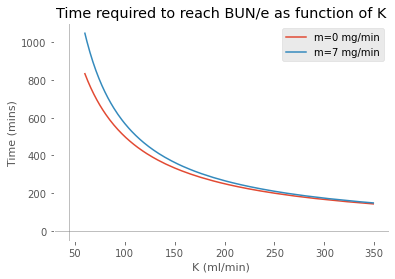

In [9]:
plt.plot(range(60,350),find_bun_e(0,V,1),label="m=0 mg/min")
plt.plot(range(60,350),find_bun_e(7,V,1),label="m=7 mg/min")
plt.xlabel("K (ml/min)",fontsize=11)
plt.ylabel("Time (mins)",fontsize=11)
plt.title("Time required to reach BUN/e as function of K")
ax = plt.gca()
ax.set_facecolor('white')
ax.axhline(0,color='gray',linewidth="0.5")
ax.axvline(44,color='gray',linewidth="0.5")
plt.legend()
plt.show()

We start at k = 60 ml/min because at lower values the plot does not reach the value since the m is higher than KC in the equation and the BUN generation rate is higher than the clearance rate.

As it can be seen, for high K values (more or less over 200 ml/min), the simplification that when the dialyzer is open m=0 mg/min can be done without remarkable changes.

### d) Find the following values
**Assume an starting BUN of 100mg%. Find the days required to achieved a stationary state, the mean value of BUN over time and the peak to peak value of BUN under the next conditions.**

### Time to reach the stationary state

The time to reach the stationary state is being found by looking at the peaks and seeing at which time the concentration at the peaks is the same. Because the threshold can change, the value of the stationary state can vary. In our case we have considered a **threshold of 0.01 mg/ml** which we consider as a low value in which the difference is not significant.

In [10]:
m = 7
V = 50000
n_sem = 3 #consider 3 weaks to have enough time
mean_values = list()
for i in range(len(k_vals)):
        tsem=7*24*60*n_sem
        nses = k_vals[i][0][0]*n_sem
        td = k_vals[i][0][1]
        tcd = tsem/nses
        ts2 = range(tsem)
        print(f'==========================\n\nMODEL {labels[i]}\n')
        Y_res=odeint(equ,yo,ts2,args=(m,V,k_vals[i][1]),hmax=1.0)
        peaks_idx = [x for x in range(1,len(Y_res)-1) if (Y_res[x]>Y_res[x-1]) and (Y_res[x]>Y_res[x+1])]
        for j in range(1,len(peaks_idx)):
            if abs(Y_res[peaks_idx[j]]-Y_res[peaks_idx[j-1]])<0.01: #they are not exactly but we fix a threshold
                idx = peaks_idx[j]
                print(f'Time to start stationary state is: {ts2[idx]} min')
                print('The mean value of BUN is: {:0.4f} mg/ml'.format(np.mean(Y_res[idx:])))
                mean_values.append(np.mean(Y_res[idx:]))
                max_stationary = Y_res[idx]
                for n in range(len(Y_res[idx:])):
                    if Y_res[idx+n]<Y_res[idx+n+1]:
                        min_stationary = Y_res[idx+n]
                        break
                distance_peak_to_peak = max_stationary[0]-min_stationary[0]
                print('Peak to peak value: {:0.4f} mg/ml'.format(distance_peak_to_peak))
                print('Min value: {:0.4f} mg/ml; Max value: {:0.4f} mg/ml\n'.format(min_stationary[0], max_stationary[0]))
                break


MODEL HD3x

Time to start stationary state is: 13440 min
The mean value of BUN is: 0.4350 mg/ml
Peak to peak value: 0.4418 mg/ml
Min value: 0.2185 mg/ml; Max value: 0.6603 mg/ml


MODEL HD6x

Time to start stationary state is: 10080 min
The mean value of BUN is: 0.3023 mg/ml
Peak to peak value: 0.2171 mg/ml
Min value: 0.1979 mg/ml; Max value: 0.4150 mg/ml


MODEL HD6xn

Time to start stationary state is: 6720 min
The mean value of BUN is: 0.1876 mg/ml
Peak to peak value: 0.1813 mg/ml
Min value: 0.1035 mg/ml; Max value: 0.2849 mg/ml



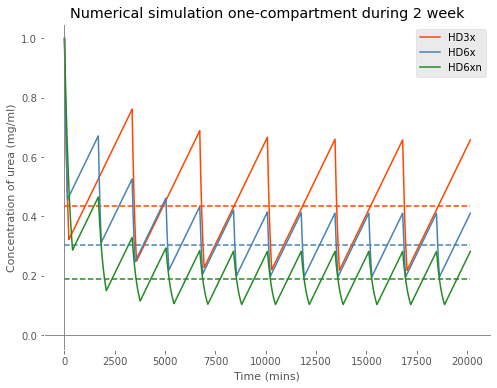

In [11]:
# We can visualize the mean BUN with an horizontal line
n_sem = 2
list_colors = ["orangered","steelblue","forestgreen"]
plot_model(k_vals, n_sem=n_sem, labels=labels, V=V, m=m, yo=yo); #it's possible to change conditions
for x in range(len(mean_values)):
    plt.hlines(mean_values[x],0, 7*24*60*n_sem, colors=list_colors[x], linestyles='dashed')

**Mean value**: the mean value will depend on the period of time, we will take 2 weeks to have an stationary value. It is shown in the plot by the dashed lines.

**Peak to peak value**: subtraction of the maximum and minimum values in the stationary state

## 2. Solute removal modeling using two-compartment model

With the one-compartment model, it is not possible to explain the inbound and rebound associated to actual BUN data. This is why we have to modelize as a two-compartment model.

**Repeat the procedure of subsection 2.1, using just one of the three dialysis cases, to show that the inbound and rebound phenomena can be catched-up by the two-compartment model. Make a parameter sweep on B from 500 to 1500 mL/min. Modify the equation model accordingly.**

In [12]:
# Conditions for the first case 'HD3x'

k_val = 277
V=50*1000 #total volume in ml
m=7
yo=[1,1] #initial conditions
nses=3 #number of sessions
td=219 #duration of the session

In [13]:
# Define both volumes extracellular and intracellular
Vic=(2/3)*V
Vec=(1/3)*V

In [14]:
# Define a new time vector
def temps(t, k_val):
    if (t%tcd)>td:
        k=0
    else:
        k = k_val
    return k

In [15]:
# Equation modeling the behavior of a two-compartment model
def equdob(y_at_t,t,m,V,B, k_val):
    y1,y2 = y_at_t
    dy1dt = (m-B*(y1-y2))/Vic
    dy2dt = (B*(y1-y2)-temps(t, k_val)*y2)/Vec
    return  np.array([dy1dt, dy2dt])

In [16]:
# Equation to plot the two model comparting changing some parameters
def plot_two_compart(k_val, B, n_sem, nses, V=50000, m = 7, yo=[1,1]):
    global tcd, td
    tsem=7*24*60*n_sem #time of a week in minutes
    nses = nses*n_sem
    tcd=tsem/nses #time between sessions
    ts=np.linspace(0,tsem,num=1000)
    Y=odeint(equdob,yo,ts,args=(m,V,B, k_val),hmax=1.0) #calculating the equation
    plt.plot(ts,Y[:,0],label="Cic")
    plt.plot(ts,Y[:,1],label="Cec")
    plt.xlabel("Time (min)",fontsize=11)
    plt.ylabel("Concentration (mg/ml)",fontsize=11)
    plt.title(f"Behavior of a two compartment model during {n_sem} week")
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.axhline(0,color='gray',linewidth="0.5") # x = 0
    ax.axvline(0,color='gray',linewidth="0.5") # y = 0
    plt.legend()
    plt.show()
    print()

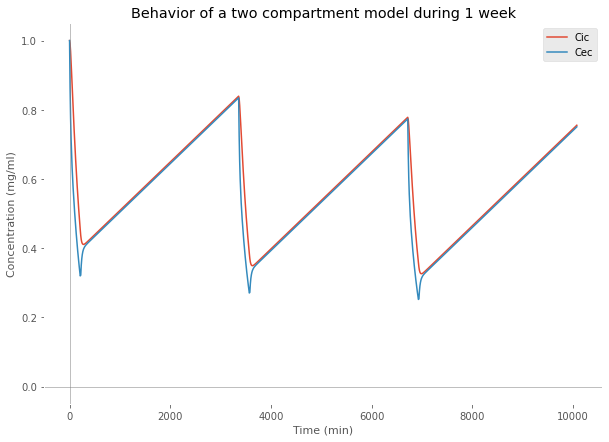

In [17]:
# We plot the results
plt.figure(figsize=(10,7))
plot_two_compart(k_val, B=500, n_sem=1, nses=3, V=V, m=7, yo=yo)

This graph shows how the model behaves when we are considering it as a two-compartment model where a phenomena of the intradialytic drop takes place in the extracellular compartment. It's time to see how the behavior changes at different B values.

In [18]:
Bs = np.arange(500, 1501, 500)
print(Bs)

[ 500 1000 1500]


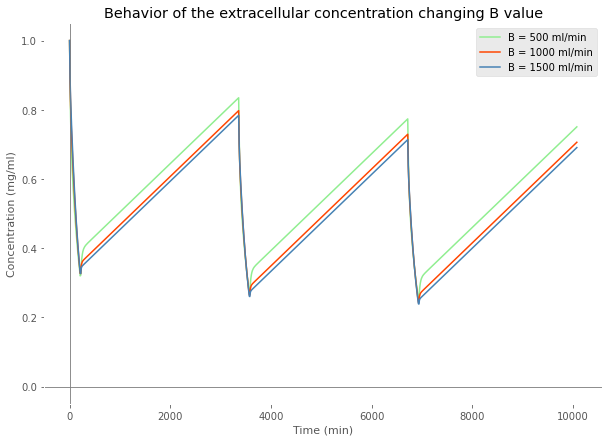

In [19]:
plt.figure(figsize=(10,7))
colors = ["lightgreen","orangered","steelblue"]
for B_val in Bs:
    tsem=7*24*60
    ts=np.linspace(0,tsem,num=1000)
    Y=odeint(equdob,yo,ts,args=(m,V,B_val, k_val),hmax=1.0)
    plt.plot(ts,Y[:,1], label = f'B = {B_val} ml/min', color=colors[(B_val//500)-1])
    plt.xlabel("Time (min)",fontsize=11)
    plt.ylabel("Concentration (mg/ml)",fontsize=11)
    plt.title(f"Behavior of the extracellular concentration changing B value")
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.axhline(0,color='gray',linewidth="0.5") # x = 0
    ax.axvline(0,color='gray',linewidth="0.5") # y = 0
    plt.legend()
plt.legend()

plt.show()